# Generate Theoretical Isotherms

Given a set of physical parameters and a pattern of epigenetic marks, generate a theoretical isotherm. Note that the theoretical isotherm assumes that all nucleosomes are separated by some distance such that binders on adjacent nucleosomes can interact.

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sliding_nucleosome.nucleo_arr as nuc
import sliding_nucleosome.linkers as link
from sliding_nucleosome import mc

#### Initialize Physical Parameters

In [3]:
# Specify physical parameters
J = np.atleast_2d([-3.92])
B = np.atleast_2d([-1.5])
mu = np.array([-9.5])

# Generate a methylation sequence
n_beads = 500
frac_methyl = 0.1
methyl_corr_length = 18.4
# marks = nuc.gen_meth(n_beads, frac_methyl, methyl_corr_length)
marks = np.zeros(n_beads, dtype=int)
marks[100:225] = 2
marks[275:400] = 2
marks = np.atleast_2d(marks).T

# Specify the polymer
gamma = np.ones(marks.shape[0])
nbi = np.array([2])
linker_corr_length = 45
linker_lengths = np.ones(marks.shape[0])
a = int(np.floor(15.1))
lam = -np.log(1 - 1 / linker_corr_length)

In [4]:
# Print the methylation pattern
print("Methylation Pattern (flattened, single mark):\n")
print(marks.flatten())

Methylation Pattern (flattened, single mark):

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

#### Generate Theoretical Isotherms

We calculate theoretical average binding fractions for various chemical potentials, then we plot the average binding fractions against the chemical potentials to generate a theoretical isotherm.

In [5]:
def differentiate_transfer_matrix(T):
    """Differentiate a transfer matrix with respect to mu_t.
    """
    dT = T.copy()
    dT[0, 0] = 0
    dT[0, 1] *= 0.5
    dT[1, 0] *= 0.5
    dT[1, 2] *= 1.5
    dT[2, 1] *= 1.5
    dT[2, 2] *= 2
    return dT


def compute_theoretical_binding_fraction(nuc_arr):
    
    # How many binder states exist?
    Nr = nuc_arr.Nbi[0] + 1
    
    # Compute derivatives
    dT_all = [
        differentiate_transfer_matrix(nuc_arr.T_all[:, :, i])
        for i in range(nuc_arr.n_beads)
    ]
    
    # Compute partition function and normalization factors
    Z, alphas = link.compute_partition_function(nuc_arr.T_all)
    
    # Pre-compute left and right partial matrix product
    N = nuc_arr.n_beads
    T_left = {}
    T_right = {}
    for i in range(N):
        if i == 0:
            T_left[i] = np.identity(Nr)
        else:
            T_left[i] = np.matmul(T_left[i-1], nuc_arr.T_all[:, :, i-1]) / alphas[i-1]
    for ind in range(N):
        i = N - ind - 1
        if i == N-1:
            T_right[i] = np.identity(Nr)
        else:
            T_right[i] = np.matmul(nuc_arr.T_all[:, :, i+1], T_right[i+1]) / alphas[i]
    
    # Compute derivative
    dZ = np.zeros((Nr, Nr))
    for i in range(N):
        dZ += np.matmul(np.matmul(T_left[i], dT_all[i]), T_right[i])

    # Calculate theoretical binding fraction
    theta_theory = 1 / (nuc_arr.Nbi[0] * N * Z) * np.trace(dZ)

    return theta_theory

In [15]:
# Transitions appear to occur between mu = -11.5 and -11, then again between mu = -10 to -9.75
thetas = []
all_mu = np.concatenate((
    np.linspace(-11.5, -11, 51),
    np.linspace(-10.9, -10.1, 9),
    np.linspace(-10, -9.75, 51)
))

In [16]:
for i, mu in enumerate(all_mu):
    print(f"mu index {i+1} of {len(all_mu)}")

    # Initialize the nucleosome array
    nuc_arr = nuc.NucleosomeArray(
        J = J, B = B, mu = [mu], linker_lengths = linker_lengths,
        a = a, lam = lam, marks = marks, Nbi = nbi
    )
    
    # Calculate the average binding fraction
    theta_theory = compute_theoretical_binding_fraction(nuc_arr)
    
    # Store the average binding fraction
    thetas.append(theta_theory)

mu index 1 of 111
mu index 2 of 111
mu index 3 of 111
mu index 4 of 111
mu index 5 of 111
mu index 6 of 111
mu index 7 of 111
mu index 8 of 111
mu index 9 of 111
mu index 10 of 111
mu index 11 of 111
mu index 12 of 111
mu index 13 of 111
mu index 14 of 111
mu index 15 of 111
mu index 16 of 111
mu index 17 of 111
mu index 18 of 111
mu index 19 of 111
mu index 20 of 111
mu index 21 of 111
mu index 22 of 111
mu index 23 of 111
mu index 24 of 111
mu index 25 of 111
mu index 26 of 111
mu index 27 of 111
mu index 28 of 111
mu index 29 of 111
mu index 30 of 111
mu index 31 of 111
mu index 32 of 111
mu index 33 of 111
mu index 34 of 111
mu index 35 of 111
mu index 36 of 111
mu index 37 of 111
mu index 38 of 111
mu index 39 of 111
mu index 40 of 111
mu index 41 of 111
mu index 42 of 111
mu index 43 of 111
mu index 44 of 111
mu index 45 of 111
mu index 46 of 111
mu index 47 of 111
mu index 48 of 111
mu index 49 of 111
mu index 50 of 111
mu index 51 of 111
mu index 52 of 111
mu index 53 of 111
mu

#### Plot Theoretical Isotherm

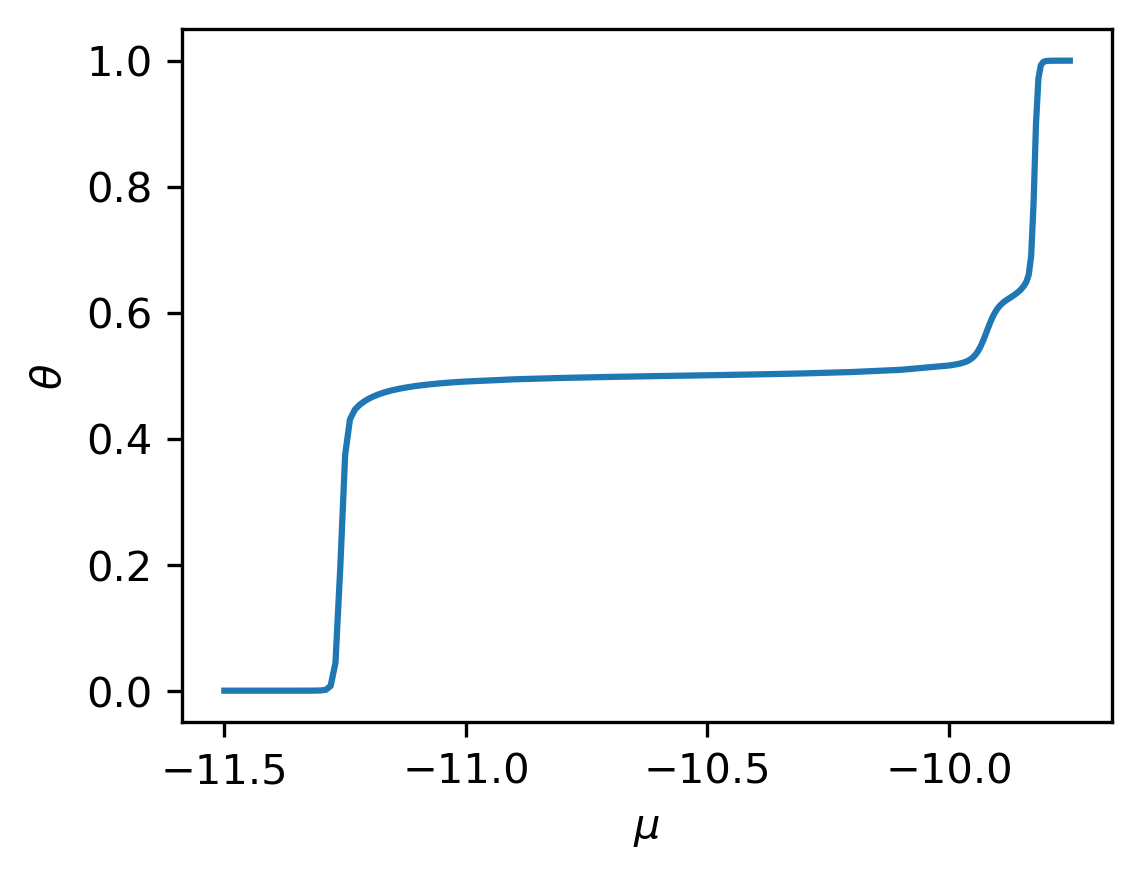

In [17]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(all_mu, thetas)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\theta$")
plt.show()